In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi']= 150
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
batch_size = 20
input_size = 5
lstm_hidden_size = 32
linear_hidden_size = 32
output_size = 6
seq_len = 30
dropout = 0.6
learning_rate = 0.0003
num_epochs = 500 

seed = 42
#seed = np.random.randint(10000000, size=1).item() #random seed

In [3]:
df = pd.read_csv('Farmgate all generated data for lstm.csv')
df.Date = pd.to_datetime(df.Date, format = '%m/%d/%Y')
df = df.set_index('Date')
df.head()

,Rainfall,Temp,Humidity,Wind Speed,Solar Rad,SO2,NO2,CO,O3,PM2.5,PM10
Date,,,,,,,,,,,
2013-01-01,0,17.0,69,0.0,183.69,10.990000,64.80,3.010000,7.770000,178.410000,515.3100
2013-01-02,0,18.4,68,2.0,203.27,13.410000,71.56,2.730000,7.780000,204.030000,473.8300
2013-01-03,0,18.9,74,0.0,188.48,10.870000,67.23,2.450000,6.910000,278.170000,462.5000
2013-01-04,0,19.9,70,2.0,251.45,12.870000,61.54,0.960000,20.990000,191.920000,402.0825
2013-01-05,0,18.7,60,2.0,362.78,15.033333,55.85,2.366667,19.496667,212.946667,341.6650


In [4]:
df_scaled = (df - df.mean())/ df.std()
df_scaled.head()

,Rainfall,Temp,Humidity,Wind Speed,Solar Rad,SO2,NO2,CO,O3,PM2.5,PM10
Date,,,,,,,,,,,
2013-01-01,-0.364317,-2.256193,-0.278817,-1.912226,-2.495260,0.213221,0.810917,1.061040,-0.115261,1.128015,2.972864
2013-01-02,-0.364317,-1.916256,-0.370281,-0.197390,-2.277708,0.407265,1.061810,0.840476,-0.114491,1.469793,2.637867
2013-01-03,-0.364317,-1.794850,0.178503,-1.912226,-2.442038,0.203599,0.901105,0.619911,-0.181466,2.458844,2.546365
2013-01-04,-0.364317,-1.552038,-0.187353,-0.197390,-1.742384,0.363966,0.689925,-0.553808,0.902442,1.308242,2.058427
2013-01-05,-0.364317,-1.843412,-1.101992,-0.197390,-0.505406,0.537429,0.478744,0.554267,0.787482,1.588745,1.570489


In [26]:
df_np_mean = df.mean().to_numpy()
df_np_std = df.std().to_numpy()

In [5]:
df_scaled.reset_index(inplace = True)
df_scaled = df_scaled.drop('Date', 1)
df_scaled.head()

,Rainfall,Temp,Humidity,Wind Speed,Solar Rad,SO2,NO2,CO,O3,PM2.5,PM10
0,-0.364317,-2.256193,-0.278817,-1.912226,-2.495260,0.213221,0.810917,1.061040,-0.115261,1.128015,2.972864
1,-0.364317,-1.916256,-0.370281,-0.197390,-2.277708,0.407265,1.061810,0.840476,-0.114491,1.469793,2.637867
2,-0.364317,-1.794850,0.178503,-1.912226,-2.442038,0.203599,0.901105,0.619911,-0.181466,2.458844,2.546365
3,-0.364317,-1.552038,-0.187353,-0.197390,-1.742384,0.363966,0.689925,-0.553808,0.902442,1.308242,2.058427
4,-0.364317,-1.843412,-1.101992,-0.197390,-0.505406,0.537429,0.478744,0.554267,0.787482,1.588745,1.570489


In [6]:
array = df_scaled.iloc[:, 0:12].values
print(array.shape)

(2191, 11)


In [7]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences): break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, 0:5], sequences[i:end_ix, 5:12]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

# convert into input/output
X, y = split_sequences(array, seq_len)
X_array = np.array(X, dtype = np.float32)
y_array = np.array(y)
print(X_array.shape)
print(y_array.shape)

(2162, 30, 5)
(2162, 30, 6)


In [8]:
class AirMeteoroDataset(Dataset):
    def __init__(self):
        self.len = X_array.shape[0]
        self.X_data = torch.from_numpy(X_array)
        self.y_data = torch.from_numpy(y_array)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [9]:
dataset = AirMeteoroDataset()
#Dataset split

import math
def roundup(x, num):
    return int(math.ceil(x / num)) * num


train_size = roundup(round(len(dataset) * 0.7), batch_size) #should I try 0.7 too?
val_size = round((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset,[train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))

In [10]:
#making mini-batches for training set

train_loader = DataLoader(dataset = train_set,
                          batch_size = batch_size,
                          shuffle = True)

In [11]:
class Model(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, linear_hidden_size, output_size, dropout):
        super(Model, self).__init__()
        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size
        self.output_size = output_size
        self.linear_hidden_size = linear_hidden_size
        self.dropout_lstm = 0
        self.relu = nn.ReLU()
        self.output_size = output_size
        self.dropout_linear = nn.Dropout(p = dropout)
        
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.lstm_hidden_size,
            dropout = self.dropout_lstm,
            batch_first = True
        )
        
        self.linear_1 = nn.Linear(self.lstm_hidden_size, self.linear_hidden_size)
        self.linear_2 = nn.Linear(self.linear_hidden_size, self.output_size)
    
        
    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences)
        
        z1 = self.linear_1(lstm_out[:, -1, :])
        a1 = self.dropout_linear(self.relu(z1))
        
        y_pred = self.linear_2(a1)
        return y_pred

In [12]:
PM10_model = Model(input_size, lstm_hidden_size, linear_hidden_size, output_size, dropout).cuda().float()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(PM10_model.parameters(), lr = learning_rate)

In [13]:
X_val = torch.empty(0, seq_len, input_size).float().cuda()
y_val = torch.empty(0, seq_len, output_size).float().cuda()

for i, (X_data, y_data) in enumerate(val_set):
    X_data = X_data.float().reshape(1, seq_len, input_size).cuda()
    X_val = torch.cat((X_val, X_data), 0)
    
    y_data = y_data.float().reshape(1, seq_len, output_size).cuda()
    y_val = torch.cat((y_val, y_data), 0)
    
print(X_val.shape)
print(y_val.shape)

torch.Size([321, 30, 5])
torch.Size([321, 30, 6])


In [14]:
all_test_loss = []
all_val_loss = []
total_iter = 0

for epoch in range(num_epochs):
    PM10_model.train()
    
    
    for i, (X_data, y_data) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X_data = X_data.cuda().float()
        y_data = y_data.cuda().float()
        y_true = y_data[:, -1, :]
        
        y_pred = PM10_model(X_data)
        loss = criterion(y_pred.reshape(batch_size, output_size), y_true)
        
        total_iter += 1
        writer.add_scalar("Loss/train", loss, total_iter)
        
        loss.backward()
        optimizer.step()
        
    if (epoch +1) % 50 == 0:
        print (f'Train loss after Epoch [{epoch+1}/{num_epochs}]: {loss.item():.6f}')
    
    all_test_loss.append(loss)
    
    
    PM10_model.eval()
    
    with torch.no_grad():
        outputs = PM10_model(X_val).cuda()
        val_loss = criterion(outputs, y_val[:, -1, :])
        all_val_loss.append(val_loss)
    

Train loss after Epoch [50/500]: 0.825232
Train loss after Epoch [100/500]: 0.561351
Train loss after Epoch [150/500]: 0.645382
Train loss after Epoch [200/500]: 0.890156
Train loss after Epoch [250/500]: 1.038694
Train loss after Epoch [300/500]: 0.315684
Train loss after Epoch [350/500]: 0.185543
Train loss after Epoch [400/500]: 0.484623
Train loss after Epoch [450/500]: 0.700132
Train loss after Epoch [500/500]: 0.416931


Text(0, 0.5, 'Loss')

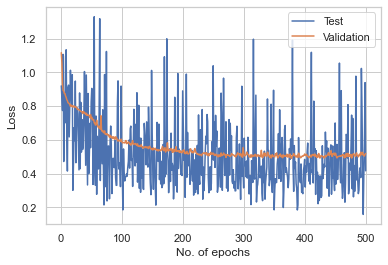

In [15]:
plt.plot(list(range(1, num_epochs + 1)), all_test_loss, label = 'Test')
plt.plot(list(range(1, num_epochs + 1)), all_val_loss, label = 'Validation')
plt.legend(loc="upper right")
plt.xlabel('No. of epochs')
plt.ylabel('Loss')

In [16]:
#tensorboard graph
dummy_inp = torch.randn(20,7,5).cuda()
writer.add_graph(PM10_model, dummy_inp)
writer.flush()

In [17]:
X_test = torch.empty(0, seq_len, input_size).float().cuda()
y_test = torch.empty(0, seq_len, output_size).float().cuda()

for i, (X_data, y_data) in enumerate(test_set):
    X_data = X_data.float().reshape(1, seq_len, input_size).cuda()
    X_test = torch.cat((X_test, X_data), 0)
    
    y_data = y_data.float().reshape(1, seq_len, output_size).cuda()
    y_test = torch.cat((y_test, y_data), 0)
    
print(X_test.shape)
print(y_test.shape)

torch.Size([321, 30, 5])
torch.Size([321, 30, 6])


In [18]:
with torch.no_grad():
    PM10_model.eval()
    outputs = PM10_model(X_test).cuda()
    test_loss = criterion(outputs, y_test[:, -1, :])
    print(test_loss)

tensor(0.3728, device='cuda:0')
